# FINM 33150: Quantitative Trading Strategies Homework 1, Futures Spread Data Characterization
#### Author: Joshua Weekes
#### Date: 1/15/2024

#### Sections:

1. Introduction

2. Package Imports

3. Helper Functions

4. Data Import

5. Analysis

6. Conclusion

# Introduction

The purpose of this notebook is to practice loading in data from the NASDAQ Data API utilyzing the quandl library and to perform basic analysis on the spreads between 2yr-10yr Treasury contracts and 5yr-10yr Treasury contracts. In this analysis I will create visualizations of the spreads between the contracts, rolling volatilities of the spreads, rolling averages of the spreads, calculate summary statistics, calculate correlation between the two pairs of spreads and the underlying contracts that the spreads are calculated from, and peform time series analysis on the spreads and the percent changes of the spreads to look for cyclical trends in the data. From this analysis I will be drawing conclusions both about the spreads themsleves and potential simple trading strategies that may be interesting if the underlying trends in the data continues into the future.

# Package Imports and API/Date Range Initialization

In [1]:
import os
import pandas as pd
import numpy as np
import quandl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import date
import datetime
import functools

global api_key
api_key = 'ykKjRrdMDZk8sVyrhPEV'
start_date = '2020-12-3'
end_date = '2023-08-31'

# Helper Functions

In [2]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(r'C:\Users\joshw\OneDrive\Desktop\UChicago\FINM_33150_quantitative_trading_strategies\data', 'quandl_data_table_downloads')
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )


def filter_data(df, years, months, start_date = '2020-12-3'):
    filtered_data = []
    current_period = pd.to_datetime(start_date)

    for year in years:
        for month in months:
            current_expiration = f"{month}{year}"
            current_data = df.loc[(df.expiration == current_expiration) & (df.index > current_period)]
            filtered_data.append(current_data)
            current_period = current_data.index[-1]

    return_df = pd.concat(filtered_data, axis=0)

    unique_contracts = return_df.groupby(return_df.index).days_termination.min()
    return_df = return_df[return_df.days_termination == return_df.index.map(unique_contracts)]
    return return_df


def performance_summary(return_data, annualization = 252):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats



# Importing Data

I could not import data in using quanl due to error that seems to stem from the NASDAQ permission problem. Instead I opt to pull the data from the csv file provided on canvas.

In [3]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm.head()

C:\Users\joshw\OneDrive\Desktop\UChicago\FINM_33150_quantitative_trading_strategies\data\quandl_data_table_downloads\AR/IVM_20240118.zip
Download finished: 290522604 bytes
Creating symlink: C:\Users\joshw\OneDrive\Desktop\UChicago\FINM_33150_quantitative_trading_strategies\data\quandl_data_table_downloads\AR/IVM_20240118.zip -> C:\Users\joshw\OneDrive\Desktop\UChicago\FINM_33150_quantitative_trading_strategies\data\quandl_data_table_downloads\AR/IVM_latest.zip


OSError: [WinError 1314] A required privilege is not held by the client: 'C:\\Users\\joshw\\OneDrive\\Desktop\\UChicago\\FINM_33150_quantitative_trading_strategies\\data\\quandl_data_table_downloads\\AR/IVM_20240118.zip' -> 'C:\\Users\\joshw\\OneDrive\\Desktop\\UChicago\\FINM_33150_quantitative_trading_strategies\\data\\quandl_data_table_downloads\\AR/IVM_latest.zip'

In [160]:
#Import the data
t_ivm = pd.read_csv(r'C:\Users\joshw\OneDrive\Desktop\UChicago\FINM_33150_quantitative_trading_strategies\data\quandl_data_table_downloads\AR\AR_IVM_excel.csv')
# t_ivm.head()

In [7]:
#Convert the date column to datetime format and set it as the index
t_ivm['date'] = pd.to_datetime(t_ivm['date'])
t_ivm.set_index('date', inplace=True)

In [159]:
#Filter the data to only include data within the desired date range and contracts that have at least 30 days to expiration
t_ivm = t_ivm.loc[(t_ivm.index >= start_date) & (t_ivm.index <= end_date) & (t_ivm.days_termination > 30) ]
# t_ivm.head()

My student id number ends with 9 and 4 but the data set for nyx_ema_ema was missing a significant amount of the expiration codes that we are analyzing so I switched to 6 and 4. For this choice in data I will be analyzing the spread between 2yr-5yr Treasuries and 5yr-10yr Treasuries.

In [57]:
# Filter data from full data set to only include the desired contracts
cbt_tu_tu = t_ivm.loc[(t_ivm.exchange_code == 'CBT') & (t_ivm.futures_code == 'TU') & (t_ivm.option_code == 'TU')]
cbt_fv_fv = t_ivm.loc[(t_ivm.exchange_code == 'CBT') & (t_ivm.futures_code == 'FV') & (t_ivm.option_code == 'FV')]
cbt_ty_ty = t_ivm.loc[(t_ivm.exchange_code == 'CBT') & (t_ivm.futures_code == 'TY') & (t_ivm.option_code == 'TY')]

In [63]:
# Define the months and years of the contract expirations for filtering
years = [2021, 2022, 2023]
months = ["H", "M", "U", "Z"]

# Filter the data to only include the desired expirations
cbt_tu = filter_data(cbt_tu_tu, years, months)
cbt_fv = filter_data(cbt_fv_fv, years, months)
cbt_ty = filter_data(cbt_ty_ty, years, months)

In [65]:
# Calculate the spreads between the future contracts
tu_ty_spread = 0.8445 * cbt_ty.futures - cbt_tu.futures
fv_ty_spread = 0.9338 * cbt_ty.futures - cbt_fv.futures

# Analysis

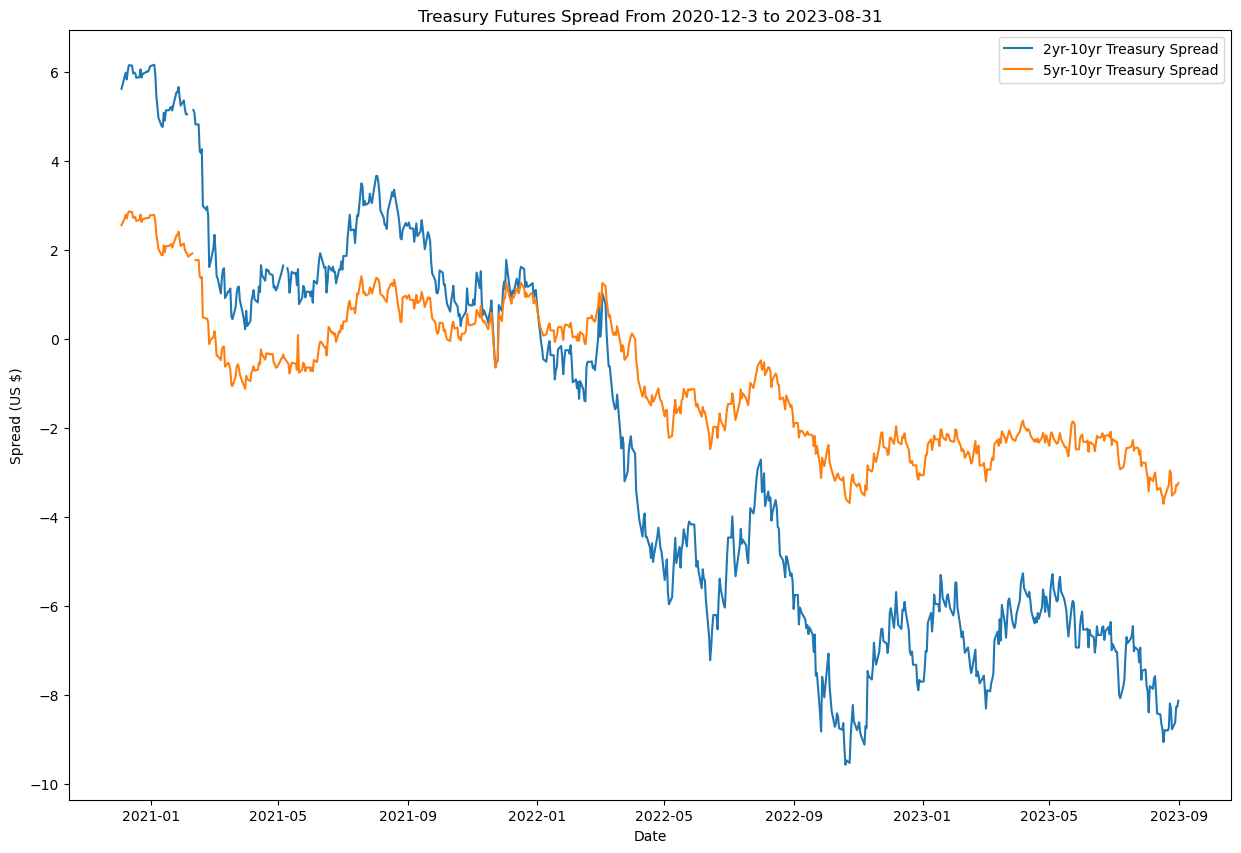

In [68]:
# Plot the spreads over the date range
plt.figure(figsize=(15, 10))
plt.plot(tu_ty_spread, label='2yr-10yr Treasury Spread')
plt.plot(fv_ty_spread, label='5yr-10yr Treasury Spread')
plt.legend()
plt.title("Treasury Futures Spread From 2020-12-3 to 2023-08-31")
plt.xlabel("Date")
plt.ylabel("Spread (US $)")
plt.show()

Over the date range we see significant decrease in the spreads between both the 2yr-10yr and 5yr-10yr Treasury Futures pairs. This decrease in the spreads stems from the 10yr futures lowering in value relative to both the 2yr and 5yr Treasury Futures. Since the pandemic we have seen the Treasury curve invert which historically has been an indicator that the economy is going into a recession and this inversion may be a large factor in the decrease of the spreads between the two contract pairs.

In [70]:
# Calculate the percentage change in the spreads
tu_ty_spread_pct_change = tu_ty_spread.pct_change(fill_method=None)
fv_ty_spread_pct_change = fv_ty_spread.pct_change(fill_method=None)

In [165]:
# Calculate summary statistics for the percent change in the spreads
tu_ty_sum_stats = performance_summary(pd.DataFrame(tu_ty_spread_pct_change), annualization = 260)
tu_ty_sum_stats.index = ['2yr - 10yr Spread Percent Change']

fv_ty_sum_stats = performance_summary(pd.DataFrame(fv_ty_spread_pct_change), annualization = 260)
fv_ty_sum_stats.index = ['5yr - 10yr Spread Percent Change']

summary_stats = pd.concat([tu_ty_sum_stats, fv_ty_sum_stats])
summary_stats

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
2yr - 10yr Spread Percent Change,42.693532,59.352230,0.719325,26.048392,687.526751,-0.292210,-0.662321,-2.584471,2021-01-04,2022-10-20,NaT
5yr - 10yr Spread Percent Change,29.839029,63.208017,0.472077,24.283160,627.249069,-0.596109,-2.184780,-2.410665,2020-12-11,2023-08-17,NaT


Overall, from the summary statistics if one is able to time the market correctly there is significant opportunities to gain from the futures spreads for both the 2yr-10r and 5yr-10yr pairs. While there is significant opportunity looking at the sharpe ratio one can conclude that the risk may outweigh the possible returns as there are many strategies that can get a sharpe higher than 0.719 which is the maximum sharpe between the two contract pairs. This is further shown when looking at the graph of the future spreads over the date range as while there are many periods where there are sharp gains in the spread the overall trend is downward so mistimings of the market could lead to significant losses.

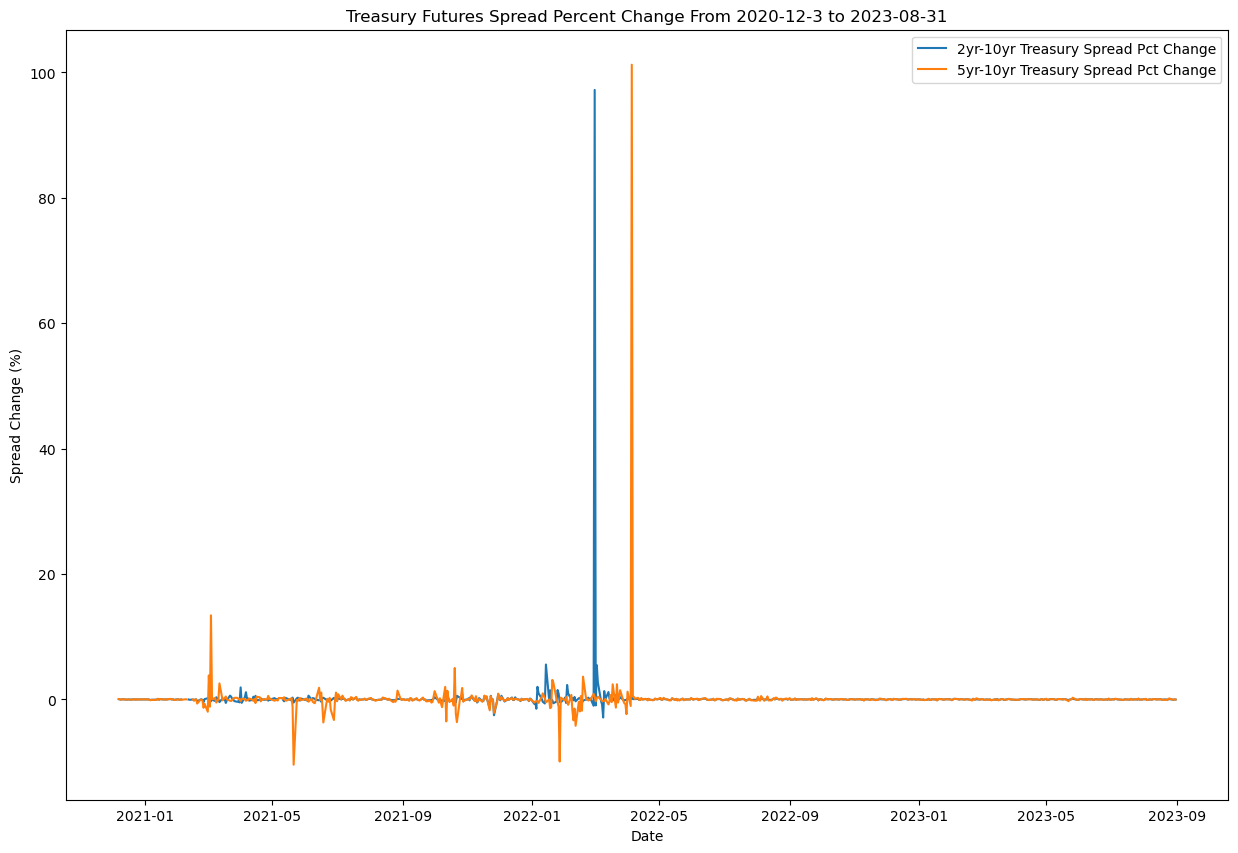

In [71]:
# Plot the percentage change in the spreads over the date range
plt.figure(figsize=(15, 10))
plt.plot(tu_ty_spread_pct_change, label='2yr-10yr Treasury Spread Pct Change')
plt.plot(fv_ty_spread_pct_change, label='5yr-10yr Treasury Spread Pct Change')
plt.legend()
plt.title("Treasury Futures Spread Percent Change From 2020-12-3 to 2023-08-31")
plt.xlabel("Date")
plt.ylabel("Spread Change (%)")
plt.show()

From the graph of the percent changes of the spreads over the date range one can see that for both spread pairs there is a high mean percent change from relatively few days over the full date range. These outliers significantly boost the mean return but also significantly add to the volatility as there are relatively large swings in the percent change of the spreads for both of the contract pairs.

In [85]:
# Calculate the rolling standard deviation of the spreads for 10, 20, and 30 day periods
tu_ty_spread_10d_vol = tu_ty_spread.rolling(10).std()
tu_ty_spread_20d_vol = tu_ty_spread.rolling(20).std()
tu_ty_spread_30d_vol = tu_ty_spread.rolling(30).std()

fv_ty_spread_10d_vol = fv_ty_spread.rolling(10).std()
fv_ty_spread_20d_vol = fv_ty_spread.rolling(20).std()
fv_ty_spread_30d_vol = fv_ty_spread.rolling(30).std()

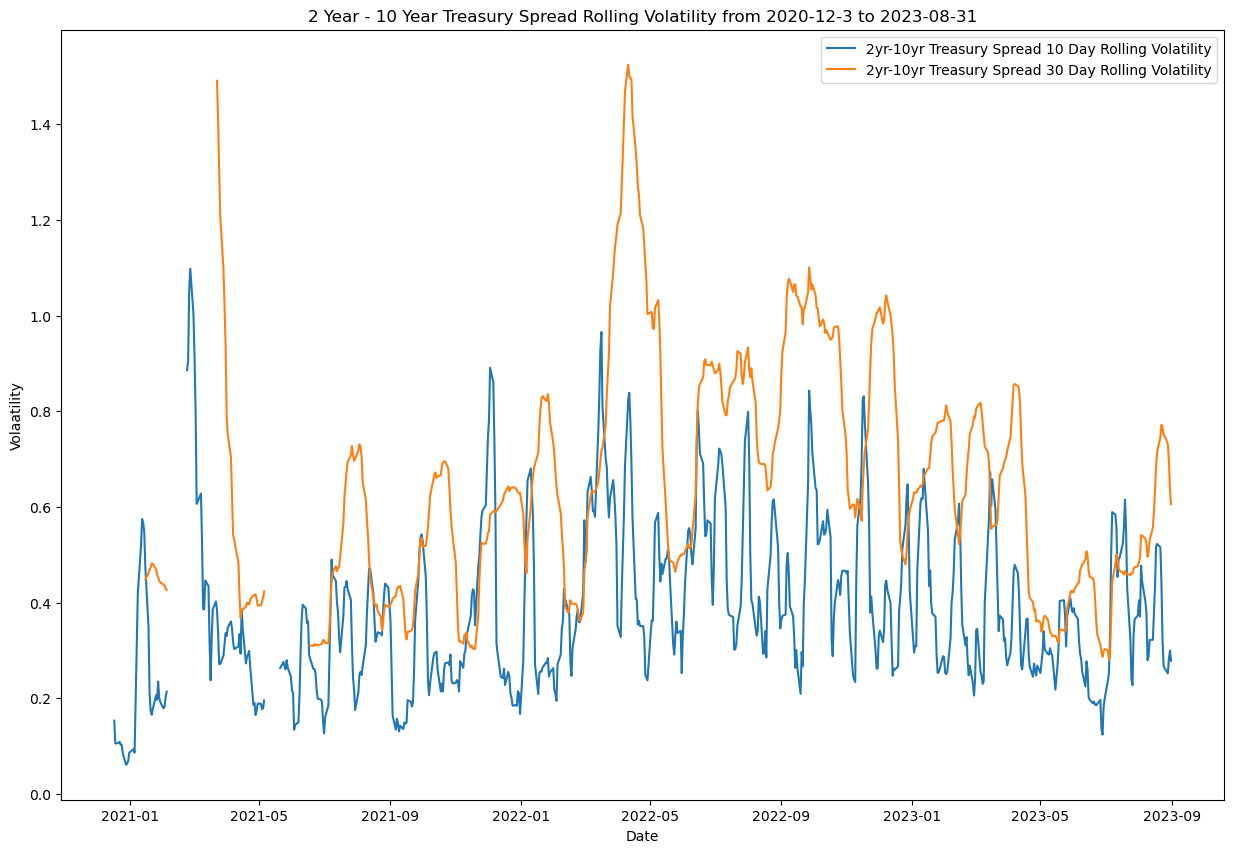

In [89]:
# Plot the rolling standard deviation of the spreads over the date range for 2yr-10yr
plt.figure(figsize=(15, 10))
plt.plot(tu_ty_spread_10d_vol , label='2yr-10yr Treasury Spread 10 Day Rolling Volatility')
# plt.plot(tu_ty_spread_20d_vol, label='2yr-10yr Treasury Spread 20 Day Rolling Volatility')
plt.plot(tu_ty_spread_30d_vol, label='2yr-10yr Treasury Spread 30 Day Rolling Volatility')
plt.legend()
plt.title("2 Year - 10 Year Treasury Spread Rolling Volatility from 2020-12-3 to 2023-08-31")
plt.xlabel("Date")
plt.ylabel("Volaatility")
plt.show()

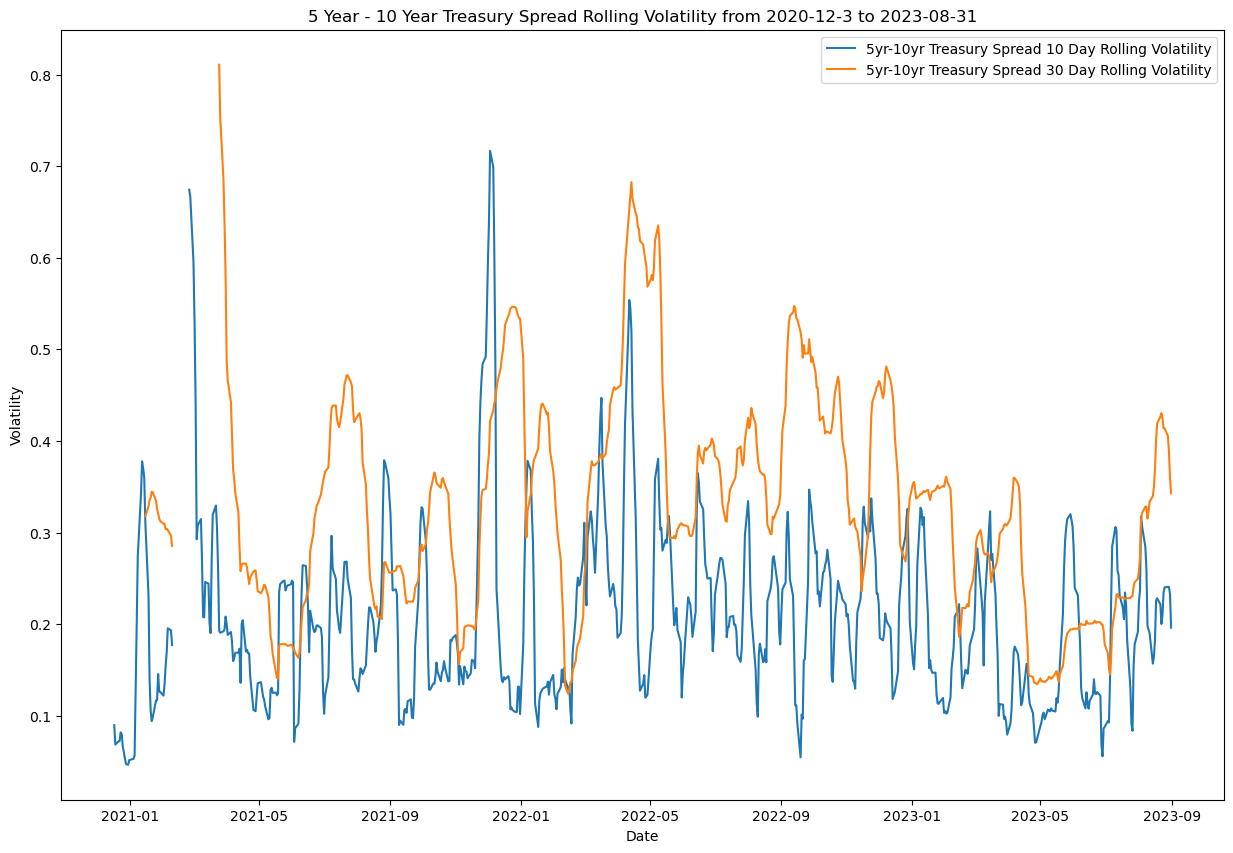

In [88]:
# Plot the rolling standard deviation of the spreads over the date range for the 5yr-10yr spread
plt.figure(figsize=(15, 10))
plt.plot(fv_ty_spread_10d_vol , label='5yr-10yr Treasury Spread 10 Day Rolling Volatility')
# plt.plot(fv_ty_spread_20d_vol, label='5yr-10yr Treasury Spread 20 Day Rolling Volatility')
plt.plot(fv_ty_spread_30d_vol, label='5yr-10yr Treasury Spread 30 Day Rolling Volatility')
plt.legend()
plt.title("5 Year - 10 Year Treasury Spread Rolling Volatility from 2020-12-3 to 2023-08-31")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

For both the 2yr-10yr Treasury spread rolling percent change and the 5yr-10yr Treasury rolling percent change there seems to be some cyclical patterns that will be analyzed further using fft. Additionally there is not a significant amount of time over the date range where the volatility remains at low levels and tends to swing up and down significantly. Overall the rolling volatility for the data seems to be very noisy and it becomes clear why over the entire date range the volatility for the spreads is so high.

In [90]:
# Calculate the rolling average of the spreads for 10, 30, and 60 days
tu_ty_spread_10d_avg = tu_ty_spread.rolling(10).mean()
tu_ty_spread_30d_avg = tu_ty_spread.rolling(30).mean()
tu_ty_spread_60d_avg = tu_ty_spread.rolling(60).mean()

fv_ty_spread_10d_avg = fv_ty_spread.rolling(10).mean()
fv_ty_spread_30d_avg = fv_ty_spread.rolling(30).mean()
fv_ty_spread_60d_avg = fv_ty_spread.rolling(60).mean()

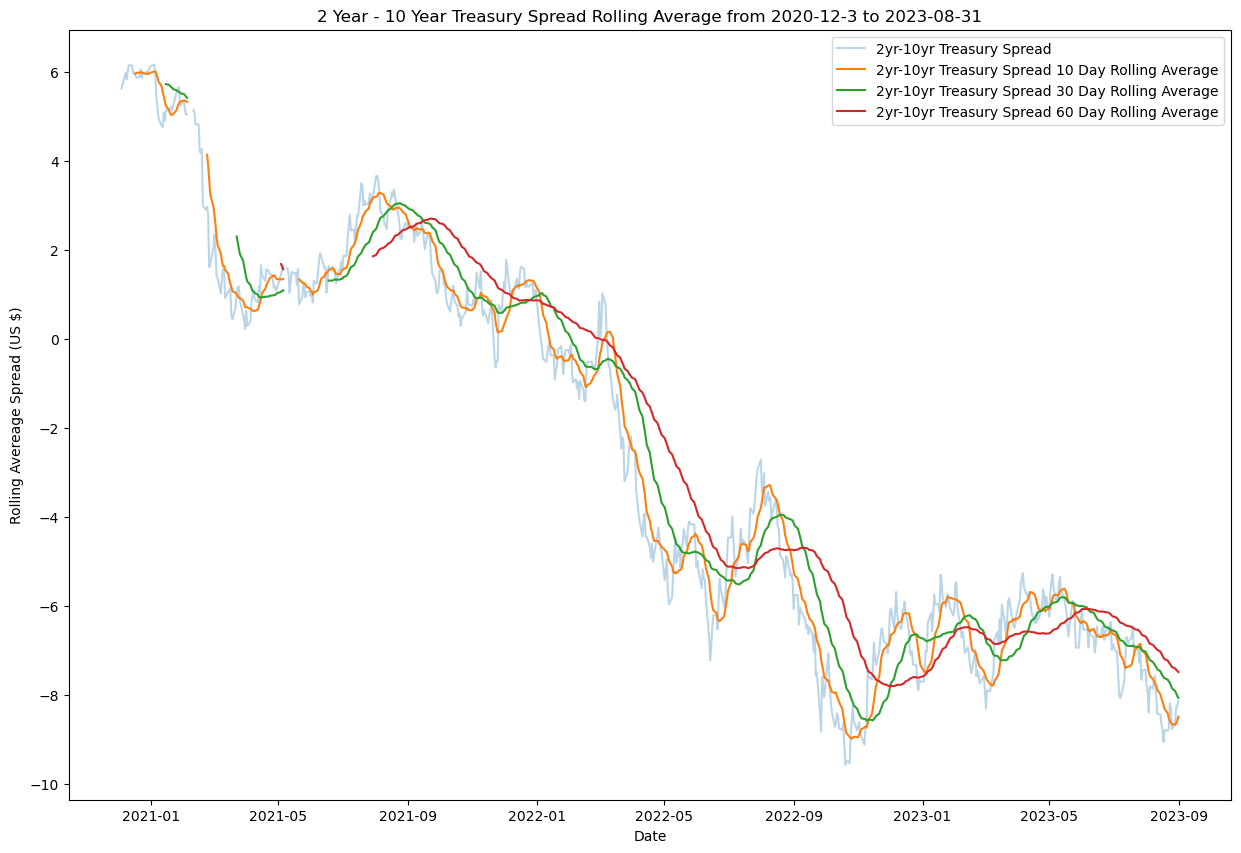

In [171]:
# Plot the rolling average of the spreads over the date range for 2yr-10yr
plt.figure(figsize=(15, 10))
plt.plot(tu_ty_spread, label='2yr-10yr Treasury Spread', alpha=0.3)
plt.plot(tu_ty_spread_10d_avg , label='2yr-10yr Treasury Spread 10 Day Rolling Average')
plt.plot(tu_ty_spread_30d_avg, label='2yr-10yr Treasury Spread 30 Day Rolling Average')
plt.plot(tu_ty_spread_60d_avg, label='2yr-10yr Treasury Spread 60 Day Rolling Average')
plt.legend()
plt.title("2 Year - 10 Year Treasury Spread Rolling Average from 2020-12-3 to 2023-08-31")
plt.xlabel("Date")
plt.ylabel("Rolling Avereage Spread (US $)")
plt.show()

From looking at the rolling averages of the spreads between the 2yr and 10yr Treasury Futrures contracts one may be able to time the market using a simple moving average trading strategy. If one were to have access to a contract that pays when the spread increases they could buy this contract when the 10 day moving average goes above the 30 day rolling average and sell when the 10 da average falls below the 30 day average. Over the date range this seems to capture a majority of the gains of the spread between the 2 and 10 year Treasury futures and exits before a significant loss in value. For this strategy to be successful the trends that we see over the date range would have to continue. If one were to do a similar strategy using the 60 day rolling average they would miss out on a significant part of the gains and exit the position too late. If the trends did not continue or adjusted so that different day rolling averages were good indicators there could be significant consequences so in the long run one may conclude that this strategy is unsustainable.

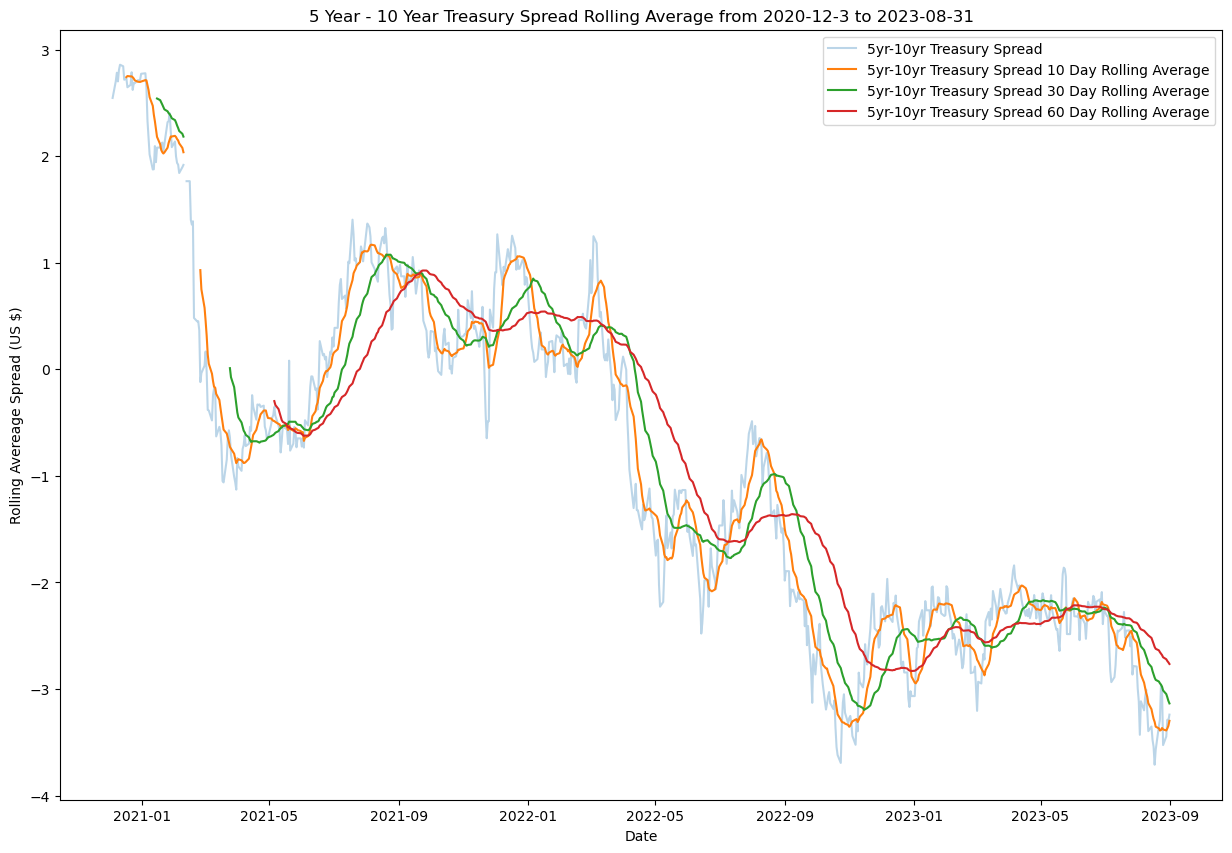

In [170]:
# Plot the rolling average of the spreads over the date range for 5yr-10yr
plt.figure(figsize=(15, 10))
plt.plot(fv_ty_spread, label='5yr-10yr Treasury Spread', alpha=0.3)
plt.plot(fv_ty_spread_10d_avg , label='5yr-10yr Treasury Spread 10 Day Rolling Average')
plt.plot(fv_ty_spread_30d_avg, label='5yr-10yr Treasury Spread 30 Day Rolling Average')
plt.plot(fv_ty_spread_60d_avg, label='5yr-10yr Treasury Spread 60 Day Rolling Average')
plt.legend()
plt.title("5 Year - 10 Year Treasury Spread Rolling Average from 2020-12-3 to 2023-08-31")
plt.xlabel("Date")
plt.ylabel("Rolling Avereage Spread (US $)")
plt.show()

When looking at the rolling averages for a 10, 30 and 60 day window for the 5yr - 10yr Treasury Futures spreads it is unclear if there is a good strategy that one can come up with trading off of a simple moving average. In some of the periods, such as midway through 2021, midway through 2022, and throughout 2023 one could do a strategy based on when the 10 day moving average goes above the 30 day moving average and exiting when it falls below. Similar to the 2yr and 5yr moving average strategy this would require the trends to stay the same and for the same window size to be a good indicator as if you tried to use the 60 day rolling average it is even worse at predicting when to enter and exit positions.

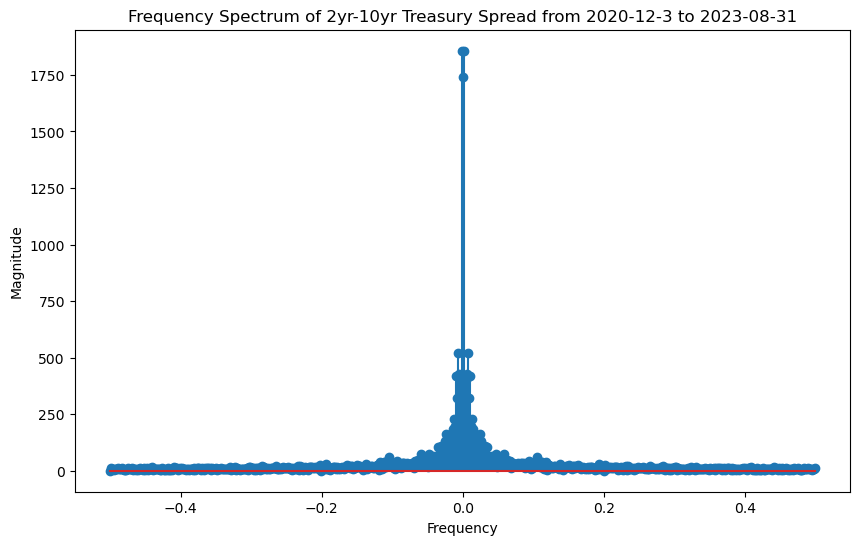

In [101]:
# Interpolate the data to fill in missing values
xi = np.arange(len(tu_ty_spread))
mask = np.isfinite(tu_ty_spread)
tu_ty_spread_fitered = np.interp(xi, xi[mask], tu_ty_spread[mask])

# Apply FFT
fft_result = np.fft.fft(tu_ty_spread_fitered)
frequencies = np.fft.fftfreq(len(tu_ty_spread_fitered))

# Compute the magnitude of the FFT result
magnitude = np.abs(fft_result)

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.stem(frequencies, magnitude)
plt.title('Frequency Spectrum of 2yr-10yr Treasury Spread from 2020-12-3 to 2023-08-31')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

From doing a fast fourier transform on the spread between the 2yr and 10 yr Treasury there are relatively minor cyclical trends in the low fequency range.

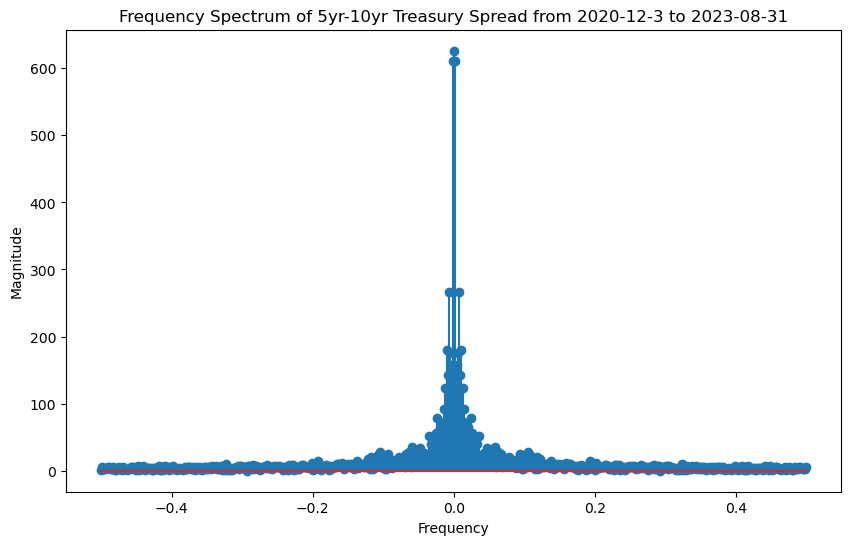

In [120]:
# Interpolate the data to fill in missing values
xi = np.arange(len(fv_ty_spread))
mask = np.isfinite(fv_ty_spread)
fv_ty_spread_fitered = np.interp(xi, xi[mask], fv_ty_spread[mask])

# Apply FFT
fft_result = np.fft.fft(fv_ty_spread_fitered)
frequencies = np.fft.fftfreq(len(fv_ty_spread_fitered))

# Compute the magnitude of the FFT result
magnitude = np.abs(fft_result)

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.stem(frequencies, magnitude)
plt.title('Frequency Spectrum of 5yr-10yr Treasury Spread from 2020-12-3 to 2023-08-31')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

Similarly to the 2yr-10yr spreads when calculating a fast fourier transform on the spreads between the 5yr-10yr contracts there are more defined cyclical trends in low frequency ranges.

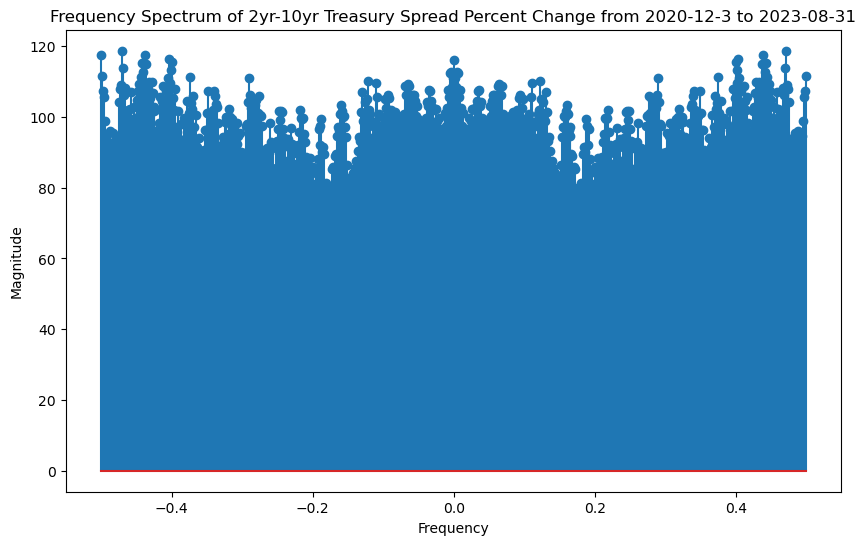

In [119]:
# Interpolate the data to fill in missing values
xi = np.arange(len(tu_ty_spread_pct_change))
mask = np.isfinite(tu_ty_spread_pct_change)
tu_ty_spread_pct_change_fitered = np.interp(xi, xi[mask], tu_ty_spread_pct_change[mask])

# Apply FFT
fft_result = np.fft.fft(tu_ty_spread_pct_change_fitered)
frequencies = np.fft.fftfreq(len(tu_ty_spread_pct_change_fitered))

# Compute the magnitude of the FFT result
magnitude = np.abs(fft_result)

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.stem(frequencies, magnitude)
plt.title('Frequency Spectrum of 2yr-10yr Treasury Spread Percent Change from 2020-12-3 to 2023-08-31')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

When performing fourier analysis on the percent changes between the 2yr-10yr spreads there are alot of peaks at different frequencies and there are not any peaks that indicate a significant cyclical trend for that frequency. There are some sections of frequencies that seem to have wide peaks but overall the magnitude is very similar across the entire frequency space.

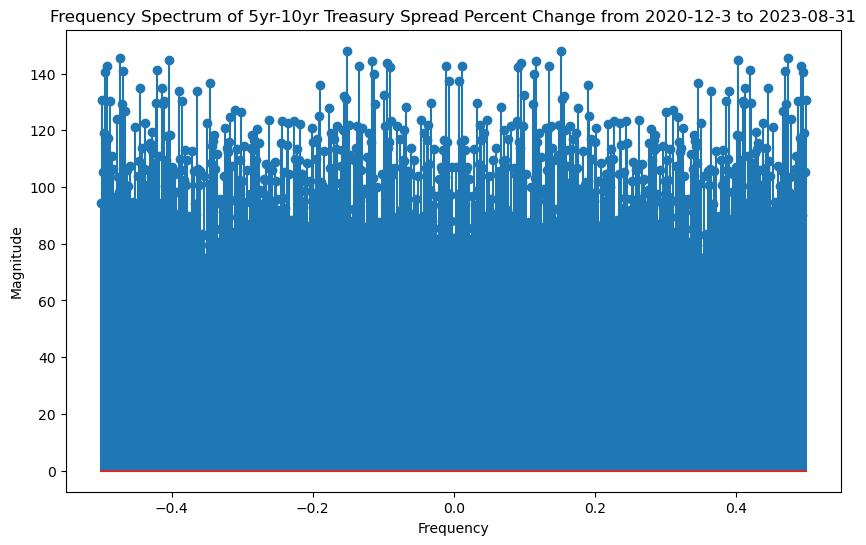

In [117]:
# Interpolate the data to fill in missing values
xi = np.arange(len(fv_ty_spread_pct_change))
mask = np.isfinite(fv_ty_spread_pct_change)
fv_ty_spread_pct_change_fitered = np.interp(xi, xi[mask], fv_ty_spread_pct_change[mask])

# Apply FFT
fft_result = np.fft.fft(fv_ty_spread_pct_change_fitered)
frequencies = np.fft.fftfreq(len(fv_ty_spread_pct_change_fitered))

# Compute the magnitude of the FFT result
magnitude = np.abs(fft_result)

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.stem(frequencies, magnitude)
plt.title('Frequency Spectrum of 5yr-10yr Treasury Spread Percent Change from 2020-12-3 to 2023-08-31')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

In the fourier analysis for the percent change in the 5yr-10yr spreads the magnitude of the peaks is relatively flat over the entire frequency space and there does not seem to be any areas of frequencies with well defined peaks.

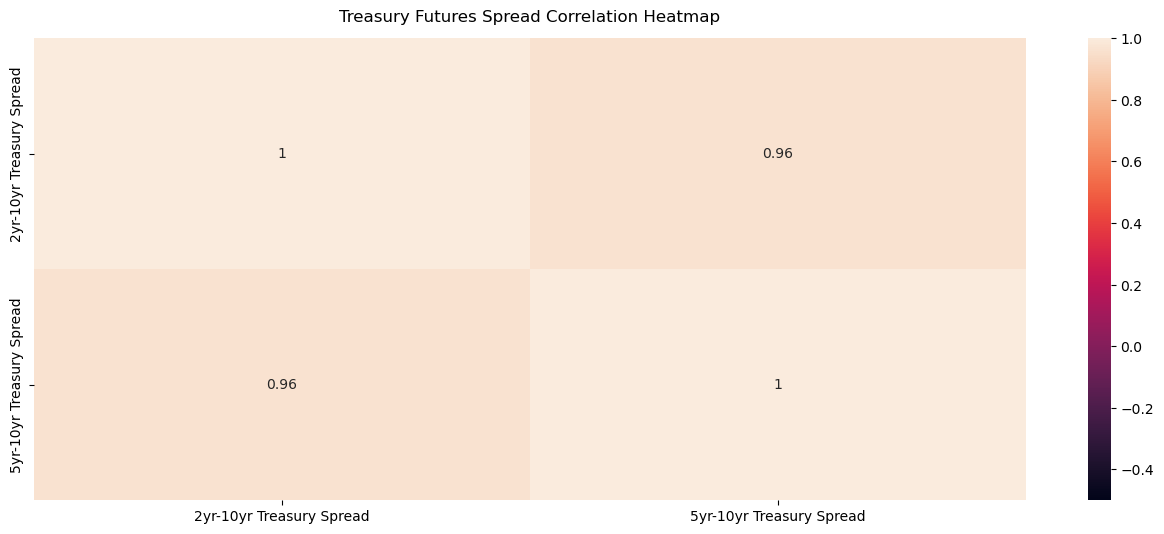

In [166]:
# Calculate the autocorrelation of the spreads
full_spread = pd.concat([tu_ty_spread, fv_ty_spread], axis=1)
full_spread.columns = ['2yr-10yr Treasury Spread', '5yr-10yr Treasury Spread']
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(full_spread.corr(), vmin=-0.5, vmax=1, annot=True)
heatmap.set_title('Treasury Futures Spread Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

As expected the correation between the two pairs of spreads is very high which makes sense as the spreads are calculated for contracts on very similar assets.

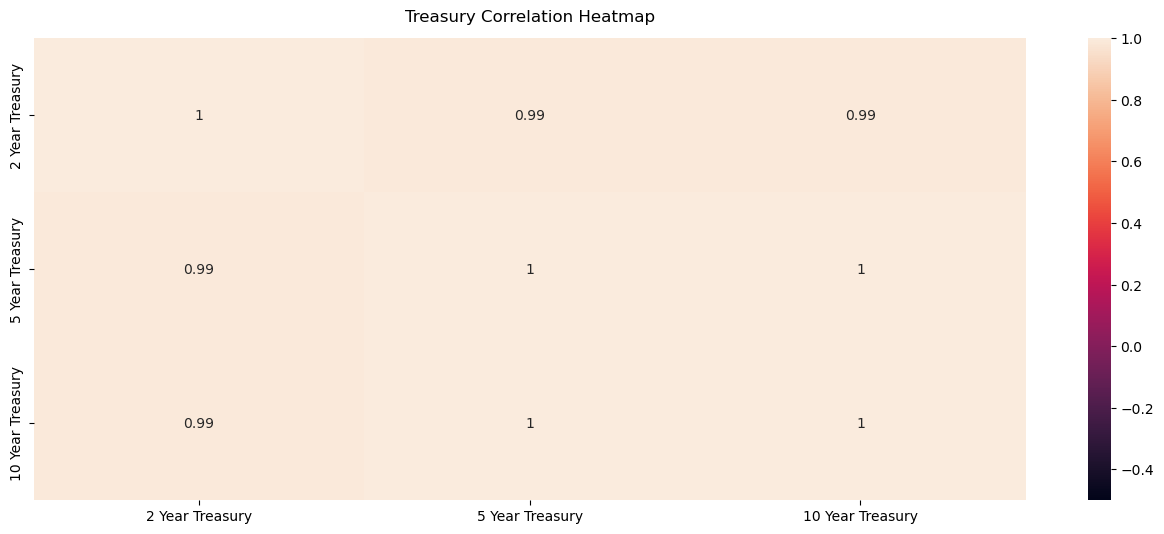

In [114]:
# Calculate the autocorrelation of the individual futures contracts
full_futures = pd.concat([cbt_tu.futures, cbt_fv.futures, cbt_ty.futures], axis=1)
full_futures.columns = ['2 Year Treasury', '5 Year Treasury', '10 Year Treasury']
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(full_futures.corr(), vmin=-0.5, vmax=1, annot=True)
heatmap.set_title('Treasury Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

The high correlation between the spreads is further shown by an almost perfect correlation between the underlying assets that the contracts are based on. These high correlations should not be surprising as the price of Treasuries should be expected to move in the market in the same directions as they are riskless and depend on very similar macroeconomic factors.

# Conclusion

From analyzing the spreads between the future contract pairs interesting conclusions can be drawn but it is unclear how useful these conclusions may be. There does not seem to be significant cyclical trends on the future spreads for both contract pairs or the percent difference in the future spreads for both pairs of contracts. There are some trends that seem to appear when looking at the moving averages of the spreads for different window sizes but in different market conditions these trends are most likely unreliable with the absense of strong cyclical trends. As expected both the spreads between the different treasury futures and the individual futures themselves have a high correlation with eachother which is to be expected as they are all contracts on different lengths of treasuries which tend to change value from the same underlying changes in the market. Overall, with the noise in the spreads between the contracts it would be difficult to come up with any strattegies that would hold the test of time or would be statistically significant.